In [7]:
import torch
from model import VitDet3D
from torch.utils.data import DataLoader
from dataset import LUNA16_Dataset, mark_bbox, collate_fn, export_as_gif
from train import compute_metrics
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model_path = "checkpoint/checkpoint-100000"
model = VitDet3D.from_pretrained(model_path).eval().to(device)

In [4]:
data_dir = "datasets/luna16"
test_dataset = LUNA16_Dataset(data_dir=data_dir, split=[9], samples_per_img = 16)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

output_dir = "eval_imgs"
os.makedirs(output_dir, exist_ok=True)

test_pred_logits = []
test_pred_bbox = []
test_gt_labels = []
test_gt_bbox = []
for i, inputs in tqdm(enumerate(test_dataloader), total=len(test_dataset)):
    with torch.no_grad():
        inputs = dict([(k,v.to(device)) for k,v in inputs.items()])
        outputs = model(**inputs)

    pred_logits = outputs["logits"].cpu().numpy()
    pred_bbox = outputs["bbox"].cpu().numpy()
    gt_labels = inputs["labels"].cpu().numpy()
    gt_bbox = inputs["bbox"].cpu().numpy()
    imgs = inputs["pixel_values"].cpu().numpy()
    
    test_pred_logits.append(pred_logits)
    test_pred_bbox.append(pred_bbox)
    test_gt_labels.append(gt_labels)
    test_gt_bbox.append(gt_bbox)

    for im, label, gt, pred in zip(imgs, gt_labels, gt_bbox, pred_bbox):
        if label==1:
            im = im[0]
            gt_im = mark_bbox(im, gt)
            pred_im = mark_bbox(im, pred)
            export_as_gif(f"{output_dir}/gt_bbox_{i}.gif", im, gt_im)
            export_as_gif(f"{output_dir}/pred_bbox_{i}.gif", im, pred_im)
            break

test_pred_logits = np.concatenate(test_pred_logits, 0)
test_pred_bbox = np.concatenate(test_pred_bbox, 0)
test_gt_labels = np.concatenate(test_gt_labels, 0)
test_gt_bbox = np.concatenate(test_gt_bbox, 0)

  0%|          | 0/88 [00:00<?, ?it/s]

In [16]:
iou = compute_metrics([(test_pred_logits,test_pred_bbox),(test_gt_labels,test_gt_bbox)])["iou"]
print("iou =",iou)
print(classification_report(test_gt_labels, test_pred_logits>0))

iou = 0.276321
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       924
           1       0.99      0.81      0.89       484

    accuracy                           0.93      1408
   macro avg       0.95      0.90      0.92      1408
weighted avg       0.94      0.93      0.93      1408



auc=0.9854097348932059


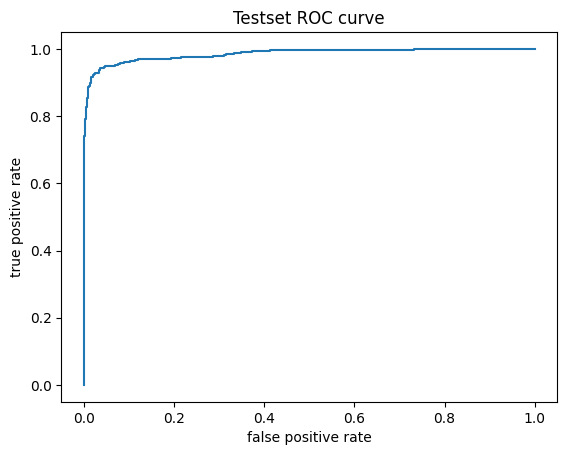

In [17]:
fpr,tpr,_=roc_curve(test_gt_labels, test_pred_logits)
ax = plt.subplot(1,1,1)
ax.plot(fpr,tpr)
ax.set_title("Testset ROC curve")
ax.set_xlabel("false positive rate")
ax.set_ylabel("true positive rate")
auc = roc_auc_score(test_gt_labels, test_pred_logits)
print(f"auc={auc}")